In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

2023-09-03 21:50:07.887545: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-03 21:50:09.566615: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-03 21:50:09.569542: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-03 21:50:12.440555: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_df = pd.read_csv('sample_submission.csv', index_col='id')

# Data Description

In [3]:
train_df.head()

,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
id,,,,,,,,,,,,,,,,,,,,,
0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


## Shape and Columns

In [5]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
# print('Test Descriptors')
# print(f'Shape: {test_df.shape}')
# print(test_df.columns)

Train Descriptors
Shape: (3500, 36)
Columns : Index(['target', 'O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_5', 'O2_6', 'O2_7',
       'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1',
       'NO2_2', 'NO2_3', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_2',
       'NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_1', 'BOD5_2',
       'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'],
      dtype='object')



## Missing Values

In [6]:
null_values = {'column': [], 'train_null_values': []}

for col in train_df.columns:
    train_col_null = train_df[col].isna().sum()
    # test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    # null_values['test_null_values'].append(test_col_null)
    
null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
# null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
# null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values.style.format({'train_null_perc': '{:.0%}'})


,column,train_null_values,train_total,train_null_perc
0,target,0,3500,0%
1,O2_1,0,3500,0%
20,NO2_6,0,3500,0%
21,NO2_7,0,3500,0%
22,NO3_1,0,3500,0%
23,NO3_2,0,3500,0%
24,NO3_3,0,3500,0%
25,NO3_4,0,3500,0%
26,NO3_5,0,3500,0%
27,NO3_6,0,3500,0%


# Exploratory Analysis

## Feature Selection

### Pearson Correlation

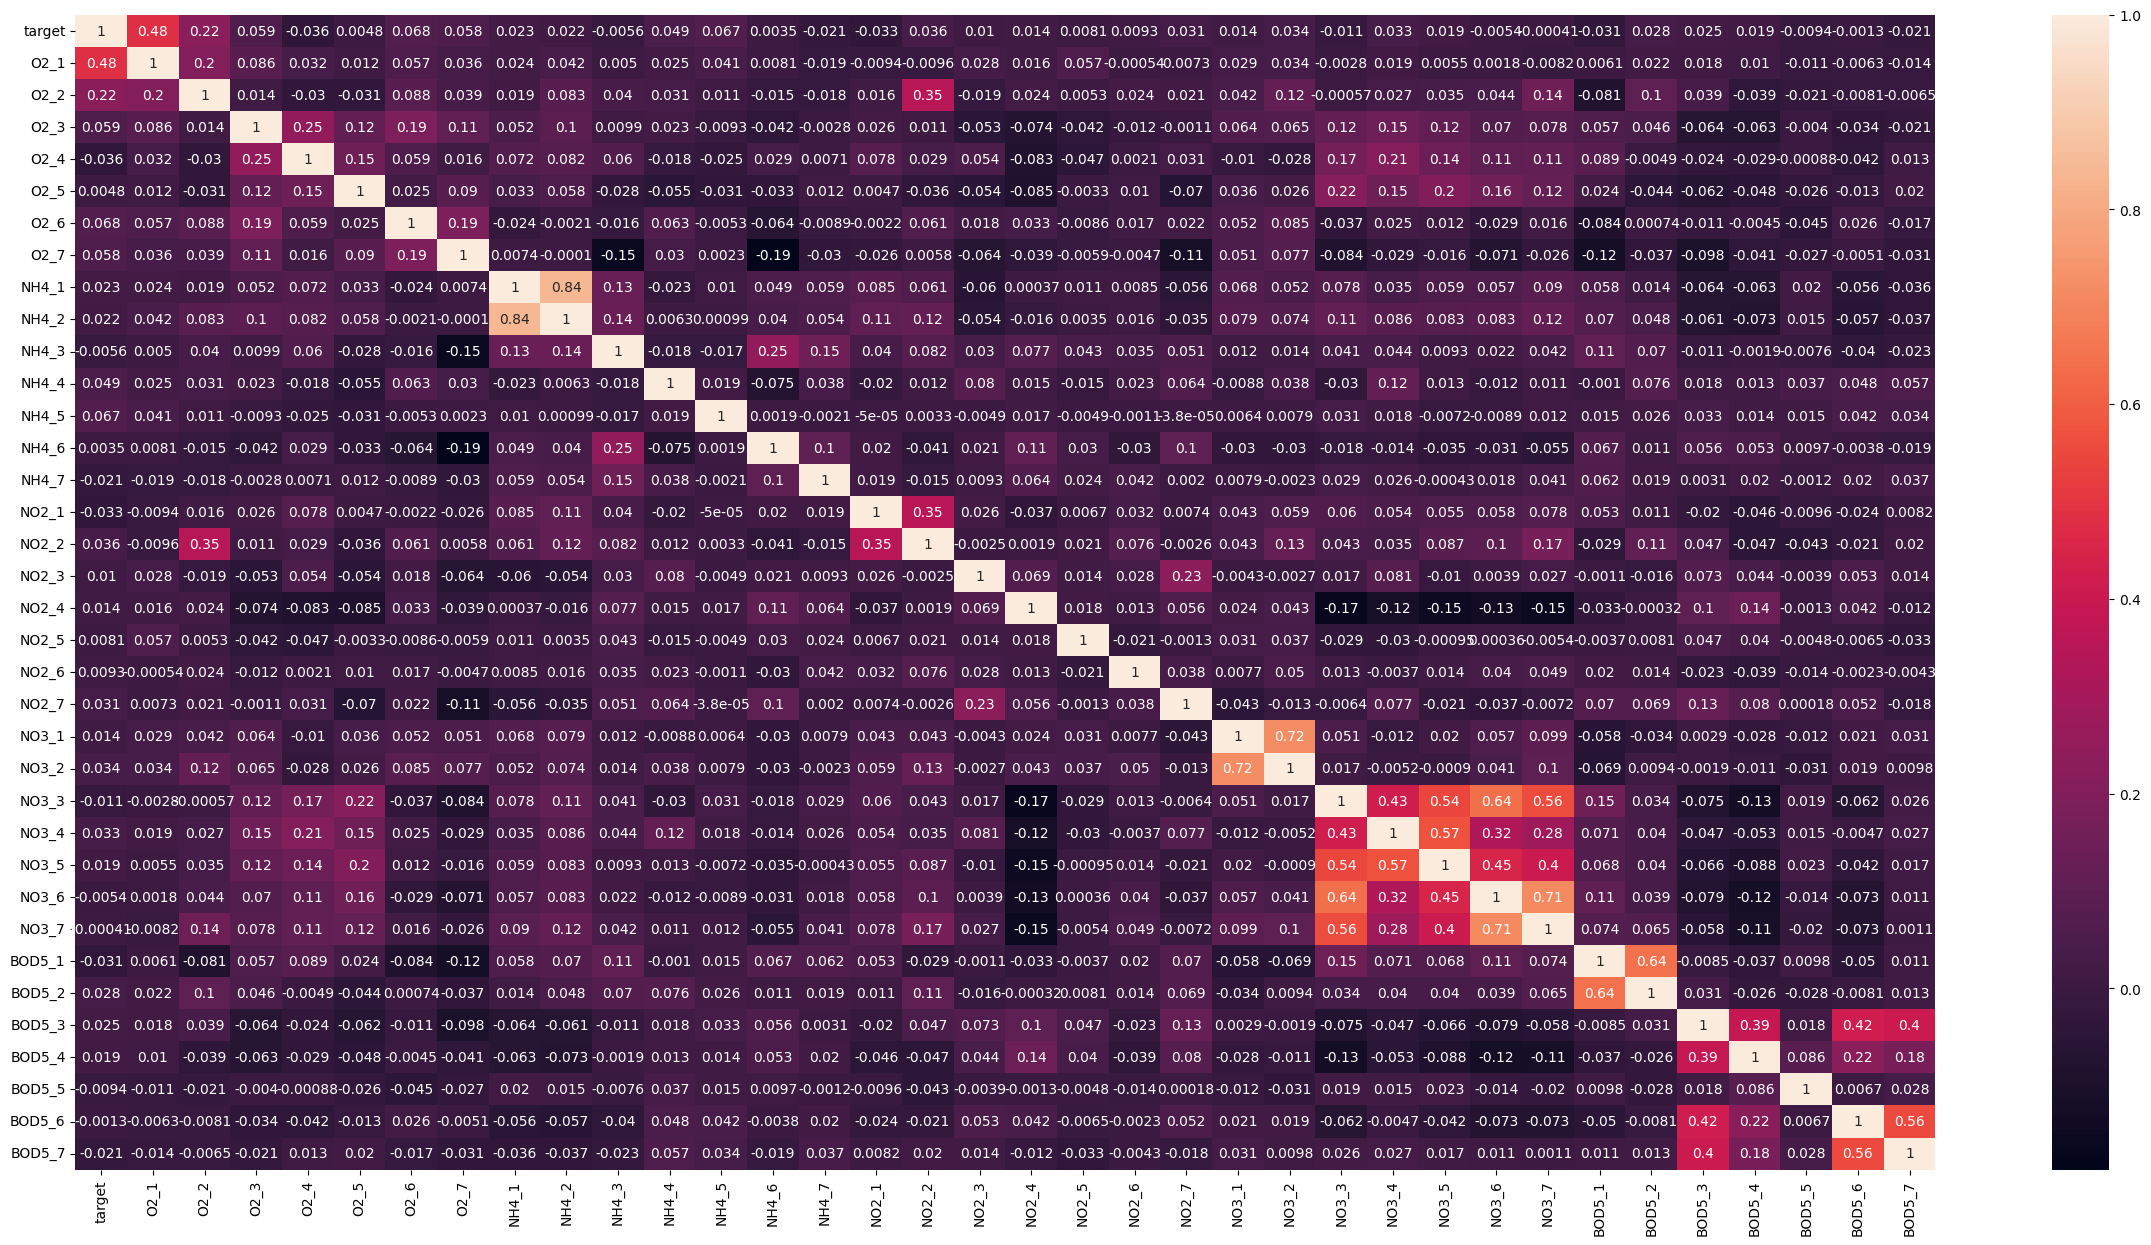

In [9]:
train_pearson = train_df.corr(method='pearson')
plt.figure(figsize=(30,15))
sns.heatmap(train_pearson, annot=True)
plt.show()

In [46]:
pearson_target = pd.DataFrame(train_pearson['target'].sort_values(key=lambda x: abs(x), ascending=False)).reset_index()
pearson_target

,index,target
0,target,1.000000
1,O2_1,0.481100
2,O2_2,0.222749
3,O2_6,0.068118
4,NH4_5,0.066669
5,O2_3,0.059053
6,O2_7,0.058312
7,NH4_4,0.048865
8,NO2_2,0.036352
9,O2_4,-0.035554


In [70]:
pearson_target[abs(pearson_target['target']) < 0.01]

,index,target
26,NO2_3,0.009995
27,BOD5_5,-0.009378
28,NO2_6,0.009271
29,NO2_5,0.008138
30,NH4_3,-0.005626
31,NO3_6,-0.005423
32,O2_5,0.004754
33,NH4_6,0.003465
34,BOD5_6,-0.001262
35,NO3_7,-0.000408


In [64]:
train_pearson_notarget = train_pearson.drop(columns='target').drop('target')
train_pearson_notarget = train_pearson_notarget.where(np.triu(np.ones(train_pearson_notarget.shape)).astype(bool)) \
                                               .stack() \
                                               .reset_index() \
                                               .rename(columns={'level_0': 'var_1', 'level_1': 'var_2', 0: 'corr'})
train_pearson_notarget = train_pearson_notarget[train_pearson_notarget['corr']!=1]
train_pearson_notarget.sort_values(by='corr', key=lambda x: abs(x))
pearson5 = train_pearson_notarget[train_pearson_notarget['corr']>=0.5].merge(pearson_target, left_on='var_1', right_on='index', how='left') \
                                                                      .merge(pearson_target, left_on='var_2', right_on='index', how='left') \
                                                                      .drop(['index_x', 'index_y'], axis=1)
pearson5['remove'] = np.where(abs(pearson5['target_x']) < abs(pearson5['target_y']), pearson5['var_1'], pearson5['var_2'])
pearson5

,var_1,var_2,corr,target_x,target_y,remove
0,NH4_1,NH4_2,0.841488,0.023005,0.022311,NH4_2
1,NO3_1,NO3_2,0.719698,0.013626,0.034108,NO3_1
2,NO3_3,NO3_5,0.542114,-0.010787,0.018877,NO3_3
3,NO3_3,NO3_6,0.641296,-0.010787,-0.005423,NO3_6
4,NO3_3,NO3_7,0.556066,-0.010787,-0.000408,NO3_7
5,NO3_4,NO3_5,0.573656,0.032578,0.018877,NO3_5
6,NO3_6,NO3_7,0.708942,-0.005423,-0.000408,NO3_7
7,BOD5_1,BOD5_2,0.644895,-0.030514,0.028343,BOD5_2
8,BOD5_6,BOD5_7,0.555149,-0.001262,-0.020524,BOD5_6


In [57]:
pearson3 = train_pearson_notarget[train_pearson_notarget['corr']>=0.3].merge(pearson_target, left_on='var_1', right_on='index', how='left') \
                                                                      .merge(pearson_target, left_on='var_2', right_on='index', how='left') \
                                                                      .drop(['index_x', 'index_y'], axis=1)
pearson3['remove'] = np.where(abs(pearson3['target_x']) < abs(pearson3['target_y']), pearson3['var_1'], pearson3['var_2'])
pearson3

,var_1,var_2,corr,target_x,target_y,remove
0,O2_2,NO2_2,0.351177,0.222749,0.036352,NO2_2
1,NH4_1,NH4_2,0.841488,0.023005,0.022311,NH4_2
2,NO2_1,NO2_2,0.354290,-0.032626,0.036352,NO2_1
3,NO3_1,NO3_2,0.719698,0.013626,0.034108,NO3_1
4,NO3_3,NO3_4,0.425284,-0.010787,0.032578,NO3_3
5,NO3_3,NO3_5,0.542114,-0.010787,0.018877,NO3_3
6,NO3_3,NO3_6,0.641296,-0.010787,-0.005423,NO3_6
7,NO3_3,NO3_7,0.556066,-0.010787,-0.000408,NO3_7
8,NO3_4,NO3_5,0.573656,0.032578,0.018877,NO3_5
9,NO3_4,NO3_6,0.324597,0.032578,-0.005423,NO3_6


### Spearman Correlation

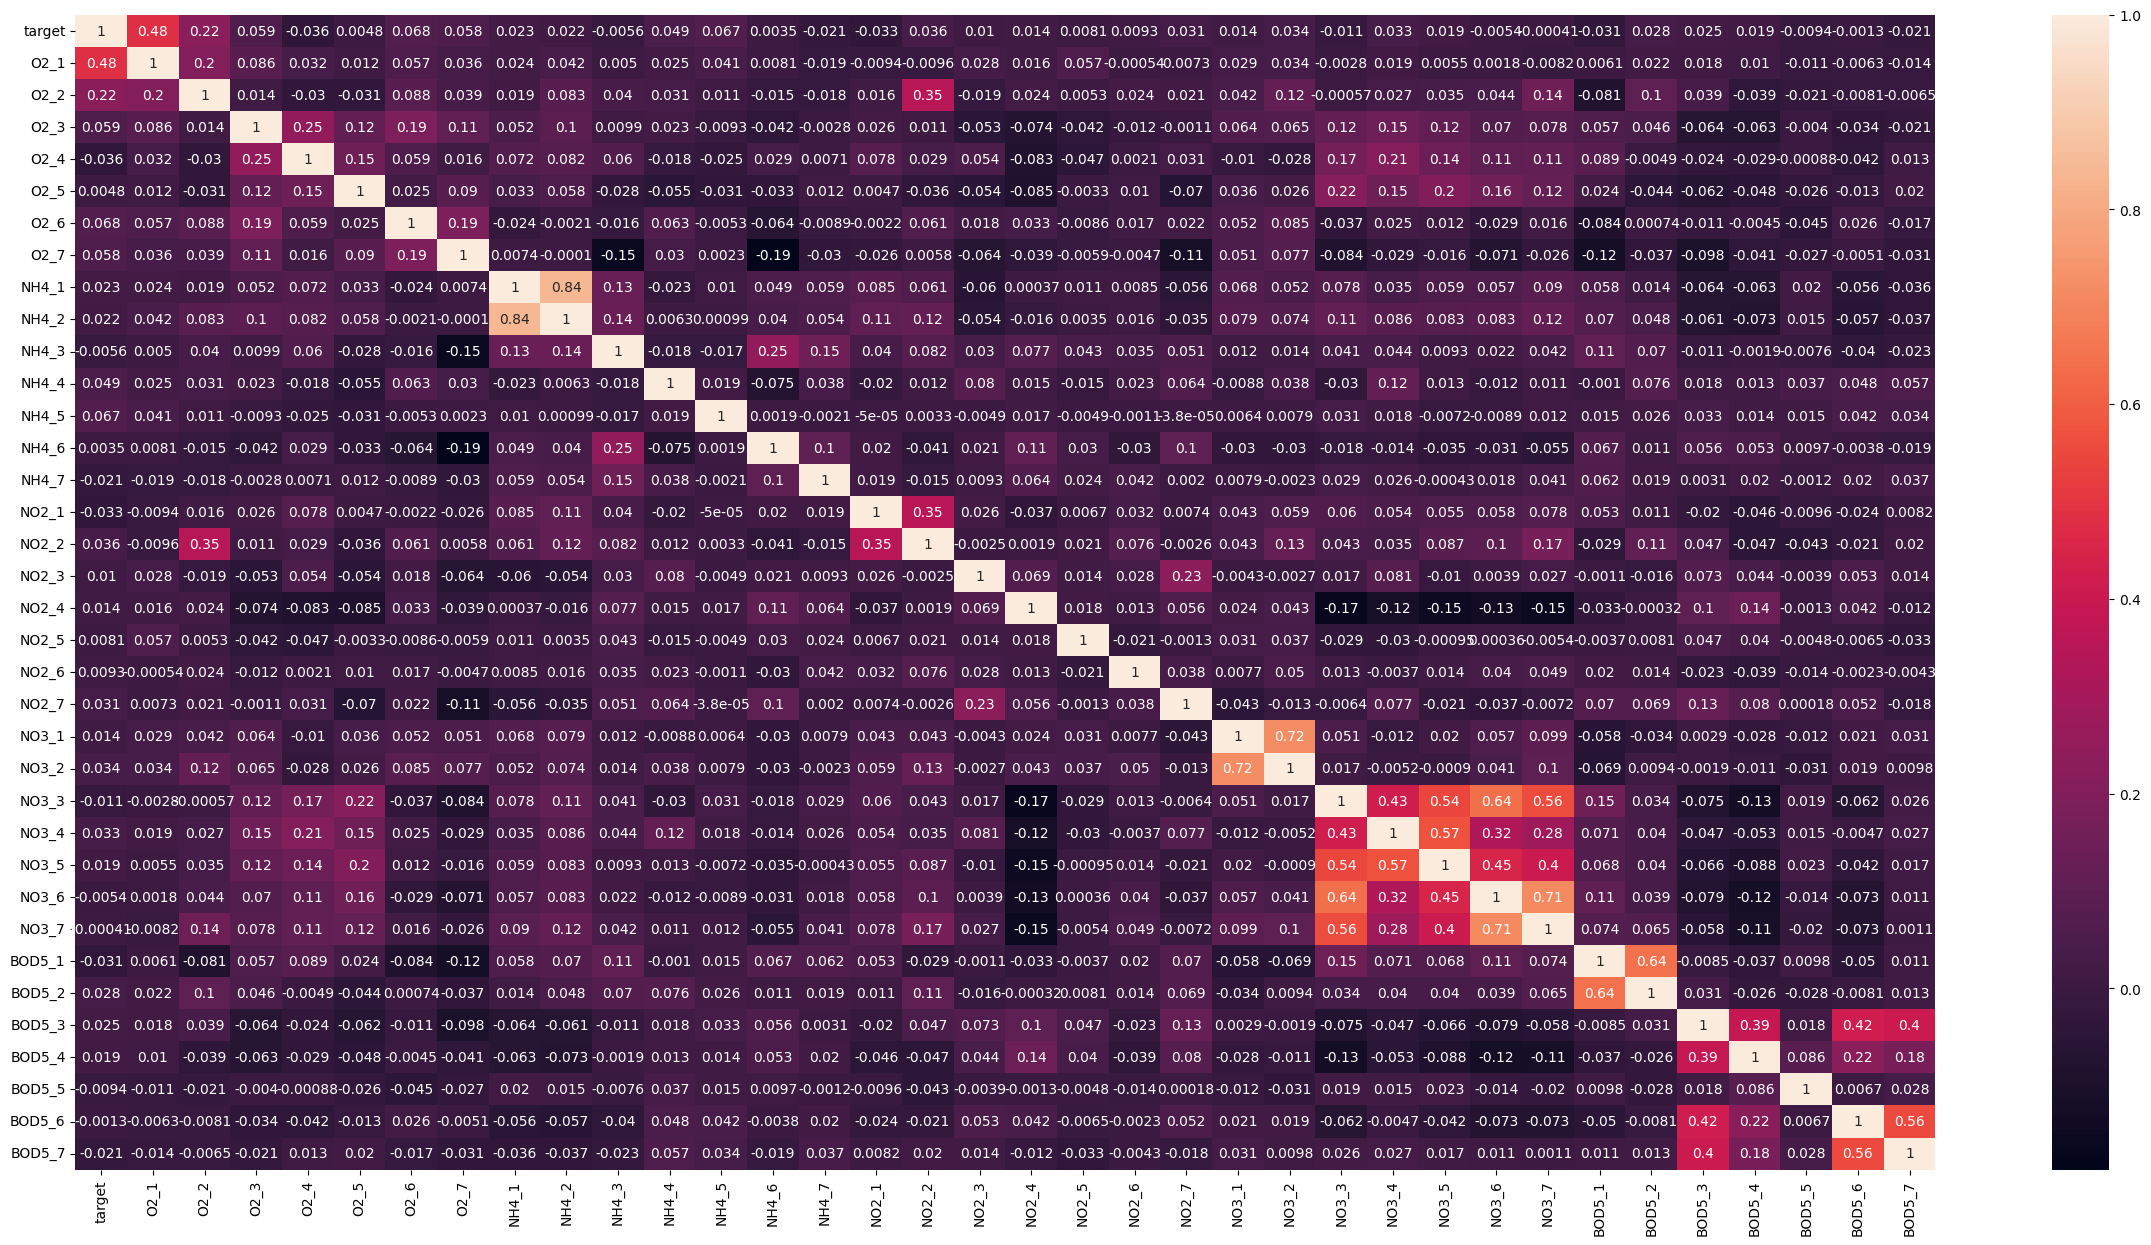

In [62]:
train_spearman = train_df.corr(method='spearman')
plt.figure(figsize=(30,15))
sns.heatmap(train_pearson, annot=True)
plt.show()

In [63]:
spearman_target = pd.DataFrame(train_spearman['target'].sort_values(key=lambda x: abs(x), ascending=False)).reset_index()
spearman_target

,index,target
0,target,1.000000
1,O2_1,0.546884
2,O2_2,0.362444
3,O2_6,0.107964
4,O2_7,0.079793
5,NH4_2,0.062305
6,O2_4,-0.060835
7,NO3_2,0.060471
8,O2_3,0.052459
9,BOD5_2,0.051931


In [65]:
train_spearman_notarget = train_spearman.drop(columns='target').drop('target')
train_spearman_notarget = train_spearman_notarget.where(np.triu(np.ones(train_spearman_notarget.shape)).astype(bool)) \
                                               .stack() \
                                               .reset_index() \
                                               .rename(columns={'level_0': 'var_1', 'level_1': 'var_2', 0: 'corr'})
train_spearman_notarget = train_spearman_notarget[train_spearman_notarget['corr']!=1]
train_spearman_notarget.sort_values(by='corr', key=lambda x: abs(x))
spearman5 = train_spearman_notarget[train_spearman_notarget['corr']>=0.5].merge(spearman_target, left_on='var_1', right_on='index', how='left') \
                                                                      .merge(spearman_target, left_on='var_2', right_on='index', how='left') \
                                                                      .drop(['index_x', 'index_y'], axis=1)
spearman5['remove'] = np.where(abs(spearman5['target_x']) < abs(spearman5['target_y']), spearman5['var_1'], spearman5['var_2'])
spearman5

,var_1,var_2,corr,target_x,target_y,remove
0,NH4_1,NH4_2,0.792937,0.032814,0.062305,NH4_1
1,NO2_1,NO2_2,0.625018,0.045349,0.048083,NO2_1
2,NO3_1,NO3_2,0.799085,0.034295,0.060471,NO3_1
3,NO3_3,NO3_6,0.524963,-0.008209,0.009252,NO3_3
4,NO3_3,NO3_7,0.503644,-0.008209,0.013252,NO3_3
5,NO3_6,NO3_7,0.617496,0.009252,0.013252,NO3_6
6,BOD5_1,BOD5_2,0.586419,-0.028049,0.051931,BOD5_1
7,BOD5_6,BOD5_7,0.542462,0.023780,-0.011708,BOD5_7


### Variance Inflation Factor

In [20]:
df = train_df.copy().drop('target', axis=1)
threshold = 5
dropped_vars = []

while True:
    vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    max_vif_pos, max_vif = np.argmax(vif), np.max(vif)
    max_vif_var = df.columns[max_vif_pos]
    
    if max_vif <= threshold:
        break
    
    df = df.drop(max_vif_var, axis=1)
    vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    dropped_vars.append([max_vif_var, max_vif])

In [21]:
dropped_vars

[['O2_6', 58.19860714627487],
 ['O2_3', 41.260818765324174],
 ['O2_4', 26.24772206112784],
 ['BOD5_2', 18.865585867889145],
 ['O2_7', 12.879546668089091],
 ['BOD5_6', 9.250296552523729],
 ['NH4_1', 8.340866694293169],
 ['O2_1', 7.995544083390712],
 ['BOD5_4', 7.467085527410679],
 ['NO3_4', 6.761193181667041],
 ['NO3_2', 6.690669713663188],
 ['BOD5_7', 6.5605255985007975],
 ['BOD5_1', 6.354277622858526],
 ['NO3_7', 5.37730792055873],
 ['NO2_4', 5.08294880756773]]

In [23]:
kept_vars = df.columns.tolist()
kept_vars_vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
pd.DataFrame({'var': kept_vars, 'vif': kept_vars_vif})

,var,vif
0,O2_2,3.178981
1,O2_5,4.932239
2,NH4_2,1.885794
3,NH4_3,4.324700
4,NH4_4,2.732859
5,NH4_5,1.086417
6,NH4_6,3.465385
7,NH4_7,4.387243
8,NO2_1,1.854996
9,NO2_2,1.805760


### Step Forward Selection

In [34]:
df = train_df.copy().drop('target', axis=1)
y = train_df['target']

model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
sfs = SequentialFeatureSelector(estimator=model, direction='forward', n_jobs=-1)
sfs.fit(df,y)

c:\Users\soh\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_selection\_sequential.py:206: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


SequentialFeatureSelector(estimator=RandomForestRegressor(max_depth=7,
                                                          n_estimators=1000,
                                                          n_jobs=-1,
                                                          random_state=42),
                          n_jobs=-1)

In [39]:
sfs.get_feature_names_out()

array(['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_6', 'NH4_1', 'NH4_2', 'NH4_3',
       'NH4_4', 'NO2_1', 'NO2_2', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7',
       'NO3_7', 'BOD5_1'], dtype=object)

### Random Forest Feature Importance

In [57]:
df = train_df.copy()
y_target = df.pop('target')
    
model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=7,
    n_jobs=-1,
    random_state=42
)
    
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

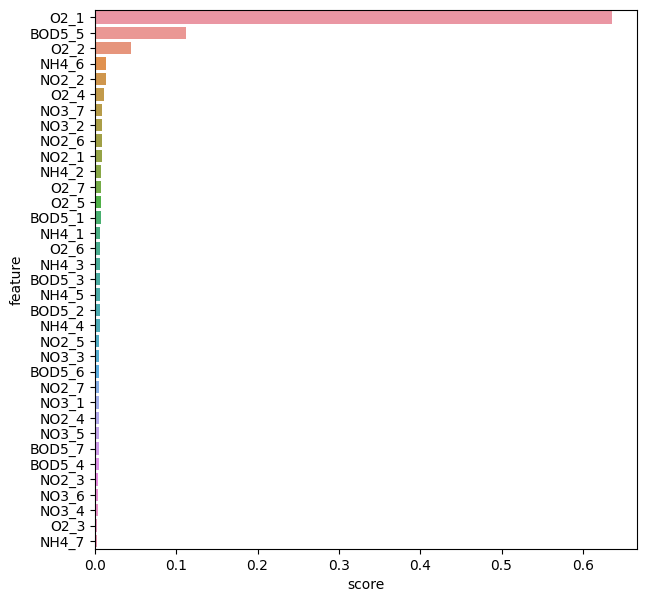

In [76]:
rf_feature_importances = pd.DataFrame({'feature': df.columns, 'score': model.feature_importances_}).sort_values('score', ascending=False)
plt.figure(figsize=(7,7))
sns.barplot(data=rf_feature_importances, x='score', y='feature')
plt.show()

## Outliers

In [4]:
outliers_df = train_df.copy()

### One Class SVM

In [5]:
df = train_df.copy()

model = SGDOneClassSVM(nu=0.55, random_state=2023)
model.fit(df)

predicted_labels = model.predict(df)
outliers = predicted_labels == -1
outliers_df['ocsvm_outlier'] = outliers

ocsvm_train_clean = outliers_df[~outliers_df['ocsvm_outlier']]
print(f'Number of Outliers: {outliers_df[outliers_df["ocsvm_outlier"]].shape[0]}')

Number of Outliers: 22


### Isolation Forest

In [6]:
df = train_df.copy()

model = IsolationForest(random_state=2023)
model.fit(df)

predicted_labels = model.predict(df)
outliers = predicted_labels == -1
outliers_df['if_outlier'] = outliers

if_train_clean = outliers_df[~outliers_df['if_outlier']]
print(f'Number of Outliers: {outliers_df[outliers_df["if_outlier"]].shape[0]}')

Number of Outliers: 72


### Autoencoders

In [7]:
tf.random.set_seed(2023)
recon_thresh = 95

df = train_df.copy()
input_dim = df.shape[1]
encoding_dim = 32

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(encoding_dim, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(df, df, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

recon_df = autoencoder.predict(df)
recon_errors = np.mean(np.square(df - recon_df), axis=1)
threshold = np.percentile(recon_errors, recon_thresh)
outliers = np.where(recon_errors > threshold)[0]
outliers_df['ae_outlier'] = False
outliers_df.loc[outliers, 'ae_outlier'] = True

ae_train_clean = outliers_df[~outliers_df['ae_outlier']]
print(f'Number of Outliers: {outliers_df[outliers_df["ae_outlier"]].shape[0]}')

2023-09-03 21:51:10.363220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-03 21:51:10.363931: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
99/99 [==============================] - 2s 6ms/step - loss: 115.6816 - val_loss: 10.5699
Epoch 2/50
99/99 [==============================] - 0s 3ms/step - loss: 87.9024 - val_loss: 8.2814
Epoch 3/50
99/99 [==============================] - 0s 3ms/step - loss: 68.9440 - val_loss: 6.7346
Epoch 4/50
99/99 [==============================] - 0s 4ms/step - loss: 55.6629 - val_loss: 4.9454
Epoch 5/50
99/99 [==============================] - 0s 4ms/step - loss: 45.0045 - val_loss: 4.1066
Epoch 6/50
99/99 [==============================] - 0s 4ms/step - loss: 35.8864 - val_loss: 3.7791
Epoch 7/50
99/99 [==============================] - 0s 3ms/step - loss: 28.0495 - val_loss: 3.1588
Epoch 8/50
99/99 [==============================] - 0s 4ms/step - loss: 21.7498 - val_loss: 2.7904
Epoch 9/50
99/99 [==============================] - 0s 3ms/step - loss: 16.7814 - val_loss: 2.5881
Epoch 10/50
99/99 [==============================] - 0s 4ms/step - loss: 12.9565 - val_loss: 2.3413
Epoch 1

### PCA

In [8]:
df = train_df.copy()
threshold = 4

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

recon_df = pca.inverse_transform(principal_components)
recon_errors = ((scaled_features - recon_df) ** 2).mean(axis=1)
outliers = np.where(recon_errors > threshold)[0]
outliers_df['pca_outlier'] = False
outliers_df.loc[outliers, 'pca_outlier'] = True

pca_train_clean = outliers_df[~outliers_df['pca_outlier']]
print(f'Number of Outliers: {outliers_df[outliers_df["pca_outlier"]].shape[0]}')

Number of Outliers: 40


### Ensemble

In [26]:
outliers_df['exclude'] = outliers_df['pca_outlier'] | outliers_df['ae_outlier']

# Removal of lowest quality labels
lowest_quality_labels = [2294, 448, 437, 309, 1684, 773, 1722, 2007]
outliers_df.loc[lowest_quality_labels, 'exclude'] = True

# Clip Target
outliers_df['target'] = outliers_df['target'].clip(7, 20)

ensem_train_clean = outliers_df[~outliers_df['exclude']]
print(f'Number of Outliers: {outliers_df[outliers_df["exclude"]].shape[0]}')

Number of Outliers: 194


# Evaluation

## Vanilla

In [35]:
df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
vanilla_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    vanilla_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.5071951023881385


In [36]:
vanilla_oof_rmse = np.array(vanilla_oof_rmse)
print(f'Mean Score: {vanilla_oof_rmse.mean()}')
print(f'Standard Deviation: {vanilla_oof_rmse.std()}')

Mean Score: 1.4159035080296982
Standard Deviation: 0.5165794543068724


## Pearson

### Multicollinearity

In [51]:
# Threshold = 0.5
rm_vars = ['NH4_2', 'NO3_1', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_2', 'BOD5_6']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
pearson5_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[rm_vars] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    pearson5_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.5036975992623103


In [59]:
pearson5_oof_rmse = np.array(pearson5_oof_rmse)
print(f'OOF Scores: {pearson5_oof_rmse}')
print(f'Mean Score: {pearson5_oof_rmse.mean()}')
print(f'Standard Deviation: {pearson5_oof_rmse.std()}')

OOF Scores: [2.33264605 0.97478425 1.05502987 1.63666867 1.05939513]
Mean Score: 1.4117047950024282
Standard Deviation: 0.5178764734899498


In [60]:
# Threshold = 0.3
rm_vars = ['NO2_2', 'NH4_2', 'NO2_1', 'NO3_1', 'NO3_3', 'NO3_5', 'NO3_6', 'BOD5_2', 'BOD5_4', 'BOD5_6', 'BOD5_7']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
pearson3_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[rm_vars] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    pearson3_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.5178200727119673


In [61]:
pearson3_oof_rmse = np.array(pearson3_oof_rmse)
print(f'OOF Scores: {pearson3_oof_rmse}')
print(f'Mean Score: {pearson3_oof_rmse.mean()}')
print(f'Standard Deviation: {pearson3_oof_rmse.std()}')

OOF Scores: [2.37483641 0.96501116 1.05794805 1.63974933 1.06759656]
Mean Score: 1.4210283019401277
Standard Deviation: 0.5333444836243444


### Multicollinearity + Dependent

In [71]:
# Threshold = 0.5, 0.01
rm_vars = ['O2_5', 'NH4_2', 'NH4_3', 'NH4_6', 'NO2_3', 'NO2_5', 'NO2_6', 'NO3_1', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_2', 'BOD5_5', 'BOD5_6']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
pearson5_01_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[rm_vars] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    pearson5_01_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.4703344949642692


In [72]:
pearson5_01_oof_rmse = np.array(pearson5_01_oof_rmse)
print(f'OOF Scores: {pearson5_01_oof_rmse}')
print(f'Mean Score: {pearson5_01_oof_rmse.mean()}')
print(f'Standard Deviation: {pearson5_01_oof_rmse.std()}')

OOF Scores: [2.17061913 1.00595735 1.10786607 1.62967901 1.09665816]
Mean Score: 1.4021559448441674
Standard Deviation: 0.4425406573638096


## Spearman

### Multicollinearity

In [66]:
# Threshold = 0.5
rm_vars = ['NH4_1', 'NO2_1', 'NO3_1', 'NO3_3', 'NO3_6', 'BOD5_1', 'BOD5_7']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
spearman5_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[rm_vars] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    spearman5_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.5112509859366043


In [67]:
spearman5_oof_rmse = np.array(spearman5_oof_rmse)
print(f'OOF Scores: {spearman5_oof_rmse}')
print(f'Mean Score: {spearman5_oof_rmse.mean()}')
print(f'Standard Deviation: {spearman5_oof_rmse.std()}')

OOF Scores: [2.35150716 0.96691772 1.06118859 1.63975499 1.06769108]
Mean Score: 1.4174119083575407
Standard Deviation: 0.5242356574486262


## Variance Inflation Factor

In [15]:
# Threshold = 2
kept_vars = ['NH4_2', 'NH4_5', 'NO2_1', 'NO2_2', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_6']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
vif2_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[x_train.columns.difference(kept_vars)] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    vif2_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.9146673533812595


In [17]:
vif2_oof_rmse = np.array(vif2_oof_rmse)
print(f'OOF Scores: {vif2_oof_rmse}')
print(f'Mean Score: {vif2_oof_rmse.mean()}')
print(f'Standard Deviation: {vif2_oof_rmse.std()}')

OOF Scores: [2.69807723 1.40933189 1.62155228 1.87240795 1.71130795]
Mean Score: 1.8625354615764658
Standard Deviation: 0.44374849686972223


In [25]:
# Threshold = 5
kept_vars = ['O2_2', 'O2_5', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2', 'NO2_3', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_3', 'NO3_5', 'NO3_6', 'BOD5_3', 'BOD5_5']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
vif5_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[x_train.columns.difference(kept_vars)] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    vif5_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.7038498514469704


In [26]:
vif5_oof_rmse = np.array(vif5_oof_rmse)
print(f'OOF Scores: {vif5_oof_rmse}')
print(f'Mean Score: {vif5_oof_rmse.mean()}')
print(f'Standard Deviation: {vif5_oof_rmse.std()}')

OOF Scores: [2.6310214  1.19549231 1.2344711  1.69600204 1.32804528]
Mean Score: 1.617006427578751
Standard Deviation: 0.5370237699067588


## Step Forward

In [41]:
kept_vars = ['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_6', 'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NO2_1', 'NO2_2', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_7', 'BOD5_1']

df = train_df.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
stepf_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    x_train[x_train.columns.difference(kept_vars)] = 0
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    stepf_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.430423333122259


In [42]:
stepf_oof_rmse = np.array(stepf_oof_rmse)
print(f'OOF Scores: {stepf_oof_rmse}')
print(f'Mean Score: {stepf_oof_rmse.mean()}')
print(f'Standard Deviation: {stepf_oof_rmse.std()}')

OOF Scores: [2.01232019 1.01518485 1.1012005  1.65981115 1.08761489]
Mean Score: 1.3752263153269477
Standard Deviation: 0.39352699217824866


## RF Feature Imporatances

In [82]:
features_by_importance = ['O2_1', 'BOD5_5', 'O2_2', 'NH4_6', 'NO2_2', 'O2_4', 'NO3_7', 'NO3_2', 'NO2_6', 'NO2_1', 'NH4_2', 'O2_7', 'O2_5', 'BOD5_1', 'NH4_1', 'O2_6', 'NH4_3', 'BOD5_3', 'NH4_5', 'BOD5_2', 'NH4_4', 'NO2_5', 'NO3_3', 'BOD5_6', 'NO2_7', 'NO3_1', 'NO2_4', 'NO3_5', 'BOD5_7', 'BOD5_4', 'NO2_3', 'NO3_6', 'NO3_4', 'O2_3', 'NH4_7']

In [100]:
rf_oof_rmse = {}

for i in range(3, 11):
    kept_vars = features_by_importance[:i]
    
    df = train_df.copy()
    y_target = df.pop('target')

    n_folds = 5
    k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
    train_oof_preds = np.zeros((df.shape[0],))
    temp_oof_rmse = []

    for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
        x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
        y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
        
        x_train[x_train.columns.difference(kept_vars)] = 0
        
        model = RandomForestRegressor(
            n_estimators=1000,
            max_depth=7,
            n_jobs=-1,
            random_state=42
        )
        
        model.fit(x_train, y_train)
        
        oof_preds = model.predict(x_valid)
        train_oof_preds[test_index] = oof_preds
        temp_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

    print(f'--> {i} Features <--')
    overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
    rf_oof_rmse.update({i: temp_oof_rmse})
    print(f'RMSE = {overall_rmse}')

--> 3 Features <--
RMSE = 1.5232344592106173
--> 4 Features <--
RMSE = 1.4947815819934258
--> 5 Features <--
RMSE = 1.4834976648701876
--> 6 Features <--
RMSE = 1.48211096661859
--> 7 Features <--
RMSE = 1.484067572964807
--> 8 Features <--
RMSE = 1.483553928305786
--> 9 Features <--
RMSE = 1.4846193776660048
--> 10 Features <--
RMSE = 1.487432099656302


In [139]:
rf_oof_rmse_df = pd.DataFrame({'features': rf_oof_rmse.keys(), 'oof_rmse': rf_oof_rmse.values()})
rf_oof_rmse_df['mean'] = rf_oof_rmse_df['oof_rmse'].apply(np.mean)
rf_oof_rmse_df['sd'] = rf_oof_rmse_df['oof_rmse'].apply(np.std)
rf_oof_rmse_df

,features,oof_rmse,mean,sd
0,3,"[2.3744607617178124, 0.99888670446668, 1.07061...",1.429918,0.524956
1,4,"[2.277453136634938, 0.9914299318913445, 1.0734...",1.411291,0.492574
2,5,"[2.254566519956723, 0.9809649357913387, 1.0708...",1.401031,0.487728
3,6,"[2.259246239699165, 0.9777426059856655, 1.0617...",1.398422,0.490988
4,7,"[2.271258795958951, 0.9651276990646667, 1.0590...",1.398133,0.497674
5,8,"[2.2685324828420996, 0.9661967952978224, 1.061...",1.398524,0.495039
6,9,"[2.269167939861555, 0.9657068182949884, 1.0628...",1.399751,0.494764
7,10,"[2.277568288660402, 0.9713553620901441, 1.0580...",1.401654,0.497817


## One Class SVM

In [26]:
df = ocsvm_train_clean.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
ocsvm55_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    ocsvm55_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.4965297861225775


In [27]:
ocsvm55_oof_rmse = np.array(ocsvm55_oof_rmse)
print(f'Mean Score: {ocsvm55_oof_rmse.mean()}')
print(f'Standard Deviation: {ocsvm55_oof_rmse.std()}')

Mean Score: 1.415165105100217
Standard Deviation: 0.4860809925967593


## Isolation Forest

In [8]:
df = if_train_clean.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
if_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    if_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.5306567727289193


In [9]:
if_oof_rmse = np.array(if_oof_rmse)
print(f'Mean Score: {if_oof_rmse.mean()}')
print(f'Standard Deviation: {if_oof_rmse.std()}')

Mean Score: 1.431035674578397
Standard Deviation: 0.543809133561881


## Autoencoder

In [26]:
df = ae_train_clean.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
ae_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    model = RandomForestRegressor(
        n_estimators=1000,
        max_depth=7,
        n_jobs=-1,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    ae_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

In [27]:
ae_oof_rmse = np.array(ae_oof_rmse)
print(f'Mean Score: {ae_oof_rmse.mean()}')
print(f'Standard Deviation: {ae_oof_rmse.std()}')

Mean Score: 1.0076299919398772
Standard Deviation: 0.03597737905681322


## PCA

In [23]:
df = pca_train_clean.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
pca_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    model = RandomForestRegressor(
        n_estimators=1000,
        n_jobs=-1,
        max_depth=7,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    pca_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 1.050116268295944


In [28]:
pca_oof_rmse = np.array(pca_oof_rmse)
print(f'Mean Score: {pca_oof_rmse.mean()}')
print(f'Standard Deviation: {pca_oof_rmse.std()}')

Mean Score: 1.0488591708365906
Standard Deviation: 0.05136746725096082


## Ensemble

In [27]:
df = ensem_train_clean.copy()
y_target = df.pop('target')

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
ensem_oof_rmse = []

for fold, (train_index, test_index) in enumerate(k_fold.split(df, y_target)):
    x_train, x_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = y_target.iloc[train_index], y_target.iloc[test_index]
    
    model = RandomForestRegressor(
        n_estimators=1000,
        n_jobs=-1,
        max_depth=7,
        random_state=42
    )
    
    model.fit(x_train, y_train)
    
    oof_preds = model.predict(x_valid)
    train_oof_preds[test_index] = oof_preds
    ensem_oof_rmse.append(mean_squared_error(y_valid, oof_preds, squared=False))

print('--> Overall Result <--')
overall_rmse = mean_squared_error(y_target, train_oof_preds, squared=False)
print(f'RMSE = {overall_rmse}')

--> Overall Result <--
RMSE = 0.8879947960236192


In [28]:
ensem_oof_rmse = np.array(ensem_oof_rmse)
print(f'Mean Score: {ensem_oof_rmse.mean()}')
print(f'Standard Deviation: {ensem_oof_rmse.std()}')

Mean Score: 0.8875892391514018
Standard Deviation: 0.027031586561952117


# Submission

In [29]:
df = train_df.copy().reset_index()

# Pearson Multicollinearity + Dependent
# rm_vars = ['id', 'O2_5', 'NH4_2', 'NH4_3', 'NH4_6', 'NO2_3', 'NO2_5', 'NO2_6', 'NO3_1', 'NO3_5', 'NO3_6', 'NO3_7', 'BOD5_2', 'BOD5_5', 'BOD5_6']
# df[rm_vars] = 0

# VIF Threshold = 2
# kept_vars = ['NH4_2', 'NH4_5', 'NO2_1', 'NO2_2', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_6']
# df[df.columns.difference(kept_vars)] = 0

# Step Forward
# kept_vars = ['O2_1', 'O2_2', 'O2_3', 'O2_4', 'O2_6', 'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NO2_1', 'NO2_2', 'NO2_4', 'NO2_5', 'NO2_6', 'NO2_7', 'NO3_7', 'BOD5_1']
# df[df.columns.difference(kept_vars)] = 0

# RF Feature Importance
# kept_vars = ['O2_1', 'BOD5_5', 'O2_2', 'NH4_6', 'NO2_2', 'O2_4']
# df[df.columns.difference(kept_vars)] = 0

# Autoencoder
df = ensem_train_clean.reset_index()
df = df[train_df.reset_index().columns]


df.to_csv('submission.csv', index=False)

In [30]:
df

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.000,9.545,9.265,8.110,8.430,7.150,0.180,...,4.950,1.730,1.800,4.800,3.150,10.665,10.465,16.645,5.750,10.37
1,1,9.10,13.533,40.900,8.770,9.265,6.015,10.070,7.150,1.107,...,20.050,9.530,7.695,4.550,6.950,2.040,5.200,5.725,2.950,2.23
2,2,8.21,3.710,5.420,8.770,9.265,4.550,10.070,7.150,0.020,...,4.580,3.025,3.960,4.935,4.950,4.725,6.075,6.750,3.500,3.17
3,3,8.39,8.700,8.100,9.500,9.200,5.200,8.670,6.670,0.280,...,8.450,2.070,1.730,6.300,4.700,3.500,6.200,8.670,2.900,7.37
4,4,8.07,8.050,8.650,7.960,9.265,3.290,10.070,7.150,0.360,...,2.020,1.730,0.760,4.800,4.970,3.950,2.800,8.400,3.500,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3301,3495,8.08,6.250,8.300,7.795,9.265,5.690,8.555,6.335,0.565,...,14.575,0.636,1.640,4.235,4.100,2.800,3.950,7.695,3.540,2.50
3302,3496,8.09,6.630,6.630,8.370,7.600,0.636,8.430,7.150,1.300,...,4.580,1.730,1.800,4.900,3.150,2.040,6.075,8.415,2.155,2.90
3303,3497,9.95,8.367,8.433,8.770,6.170,5.800,10.400,7.200,0.430,...,20.050,1.440,1.800,4.867,4.833,4.725,4.950,8.400,6.625,4.20
3304,3498,9.52,10.000,6.630,9.545,9.265,3.290,8.980,2.310,0.300,...,20.050,9.530,7.695,10.700,5.400,4.725,3.300,6.750,6.625,5.00


In [24]:
df.shape

(3306, 37)

In [46]:
train_df.shape

(3500, 36)

In [47]:
df.columns.difference(train_df.columns)

Index(['id'], dtype='object')